In [699]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture

In [700]:
# Load the datasets
data1000D = pd.read_csv('hw5/data/data1000D.csv').values
data2D = pd.read_csv('hw5/data/data2D.csv').values

In [701]:
def reconstruction_error(X, reconstruction):
    error =  np.sum((X-reconstruction)**2)
    n = X.shape[0]
    return error/n

In [702]:
def buggy_pca(X, d):
    U, S, vt = np.linalg.svd(X)
    V = vt.T
    Z = X @ V[:, :d]
    reconstruction = Z @ V[:, :d].T
    return Z, reconstruction

In [703]:
def demeaned_pca(X, d):
    xbar = X.mean(axis = 0)
    X_demeaned = X - xbar
    Z, reconstruction = buggy_pca(X_demeaned, d)
    reconstruction = reconstruction + xbar
    return Z, reconstruction

In [704]:
def normalized_pca(X,d):
    xbar = X.mean(axis = 0)
    std = X.std(axis = 0)
    X_normalized = (X - xbar) / std
    Z, reconstruction = buggy_pca(X_normalized, d)
    reconstruction = reconstruction*std + xbar
    return Z, reconstruction

In [705]:
def dro(X, d):
    '''
    A.shape = (d, D)
    b.shape = (D, )
    Z.shape = (n, d)
    z represents the low-dimensional representation of the dataset X after applying dimensionality reduction.
    '''
    n, D = X.shape
    def objective(params, X):
        A = params[:d * D].reshape(d, D)
        b = params[d * D:]
        Z = X @ A.T
        reconstruction = Z @ A + b
        return np.sum((X - reconstruction)**2) / n
    
    params0 = np.zeros(d*D + D)
    params0[:d * D] = np.random.rand(d * D)

    res = minimize(objective, params0, args=(X, ), method= 'L-BFGS-B')
    params_opt = res.x
    A_opt = params_opt[:d * D].reshape(d, D)
    b_opt = params_opt[d * D:]

    Z = X @ A_opt.T
    reconstruction = Z @ A_opt + b_opt
    return Z, reconstruction, A_opt, b_opt

In [706]:
def drlv(X, d, A_init, b_init, n_iter = 10):
    """
    A.shape: (d, D)
    """
    n, D = X.shape
    A = A_init.copy()
    b = b_init.copy()

    # Compute the reconstruction error for the DRO method
    Z_dro, reconstruction_dro, _, _ = dro(X, d)
    dro_error = reconstruction_error(X, reconstruction_dro)
    eta = dro_error

    for i in range(n_iter):

        #E-step: Compute the posterior mean of the latent variable Z given the current parameters A and b
        M = np.linalg.inv(np.eye(d) + A @ A.T)
        Z = X @ A.T @ M

        #M-step:
        ZTZ_inv = np.linalg.inv(Z.T @ Z + eta*np.eye(d))
        A_new = (X.T @ Z) @ ZTZ_inv
        b_new = np.mean(X - Z @ A_new.T, axis = 0)

        #Update A, B
        A = A_new.T
        b = b_new

         # Compute the reconstruction error for the current iteration of DRLV
        reconstruction = Z @ A + b
        error = reconstruction_error(X, reconstruction)

        # Update eta
        eta = error
        
    reconstruction = Z @ A + b
    return Z, reconstruction, A, b

In [707]:
Z_buggy, reconstruction_buggy = buggy_pca(data2D, 1)
Z_dem, reconstruction_dem = demeaned_pca(data2D, 1)
Z_norm, reconstruction_norm = normalized_pca(data2D, 1)
Z_dro, reconstruction_dro, A_init, b_init = dro(data2D, 1)
Z_drlv, reconstruction_drlv, A_drlv, b_drlv = drlv(data2D, 1, A_init, b_init)


In [708]:
# Compute reconstruction errors for 2D dataset
reconstruction_errors = {
    "Buggy": reconstruction_error(data2D, reconstruction_buggy),
    'Demeaned': reconstruction_error(data2D, reconstruction_dem),
    'Normalized': reconstruction_error(data2D, reconstruction_norm),
    "DRO":  reconstruction_error(data2D, reconstruction_dro),
    "DRLV" : reconstruction_error(data2D, reconstruction_drlv)
}


In [709]:
reconstruction_errors

{'Buggy': 0.8884316181417982,
 'Demeaned': 0.009960281682916326,
 'Normalized': 0.04844943264439049,
 'DRO': 0.009960281683011564,
 'DRLV': 0.8829008536241556}

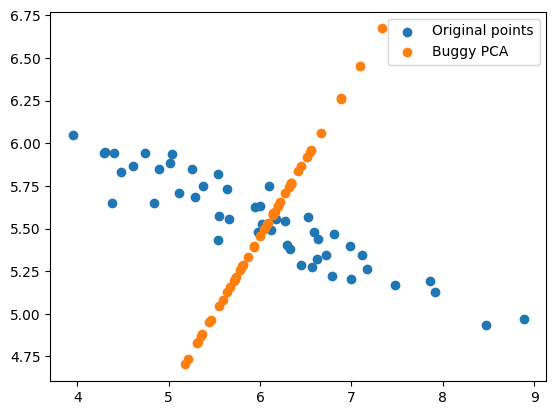

In [710]:
# Plot original points and reconstructed points for 2D dataset
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original points')
plt.scatter(reconstruction_buggy[:, 0], reconstruction_buggy[:, 1], label='Buggy PCA')
plt.legend()
plt.show()

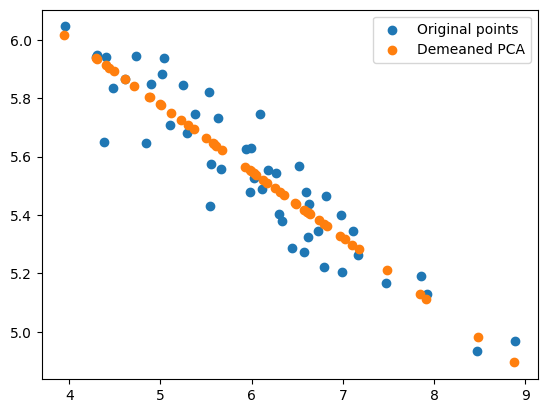

In [711]:
# Plot original points and reconstructed points for 2D dataset
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original points')
plt.scatter(reconstruction_dem[:, 0], reconstruction_dem[:, 1], label='Demeaned PCA')
plt.legend()
plt.show()

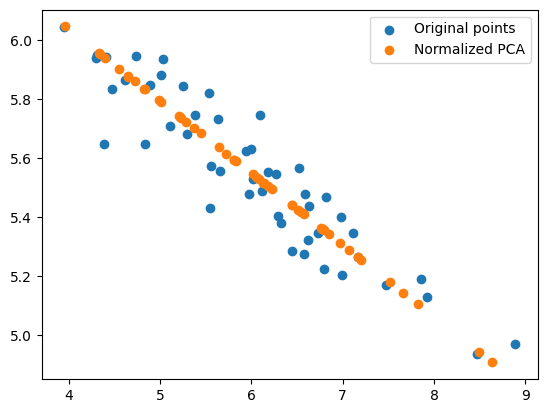

In [712]:
# Plot original points and reconstructed points for 2D dataset
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original points')
plt.scatter(reconstruction_norm[:, 0], reconstruction_norm[:, 1], label='Normalized PCA')
plt.legend()
plt.show()

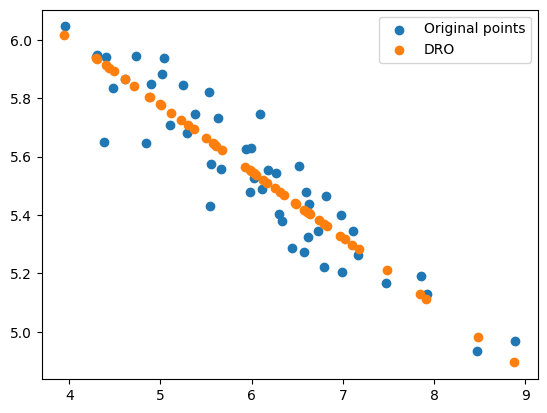

In [713]:
# Plot original points and reconstructed points for 2D dataset
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original points')
plt.scatter(reconstruction_dro[:, 0], reconstruction_dro[:, 1], label='DRO')
plt.legend()
plt.show()

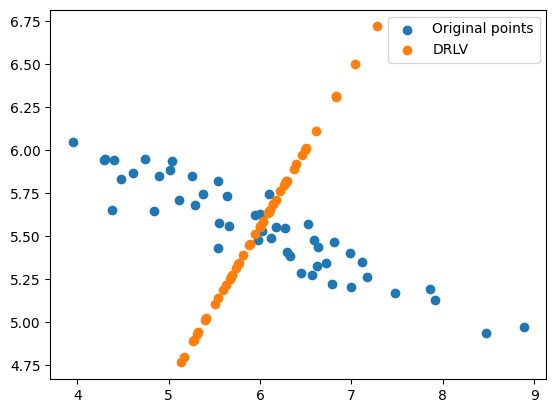

In [714]:
# Plot original points and reconstructed points for 2D dataset
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original points')
plt.scatter(reconstruction_drlv[:, 0], reconstruction_drlv[:, 1], label='DRLV')
plt.legend()
plt.show()

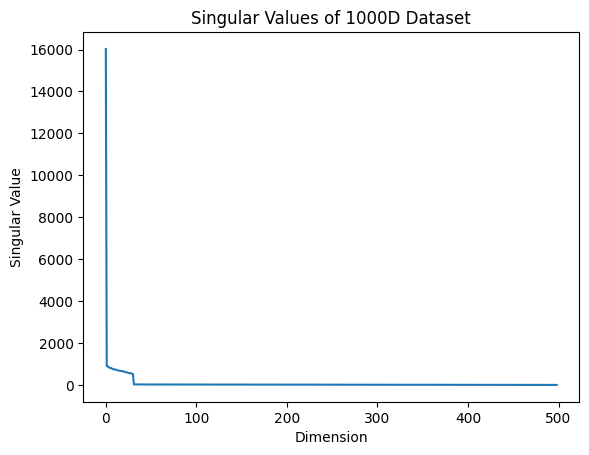

In [715]:
U_1000D, S_1000D, _ = np.linalg.svd(data1000D)
plt.plot(S_1000D)
plt.xlabel('Dimension')
plt.ylabel('Singular Value')
plt.title('Singular Values of 1000D Dataset')
plt.show()